# Text classification (multiclass) 

__Data__: Consumer complaints received about financial products and services<br>
__Data source:__ Public dataset downloaded from 
https://catalog.data.gov/dataset/consumer-complaint-database

These are real world complaints received about financial products and services. Each complaint has been labeled with a specific product; therefore, this is a supervised text classification problem. With the aim to classify future complaints based on its content, we used different machine learning algorithms can make more accurate predictions (i.e., classify the complaint in one of the product categories).

<a id='obj'></a>
## Goal:<br>
Classify consumer complaints into predefined categories.<br><br>
Classification algorithms: Linear Support Vector Machine (LinearSVM), Random Forest, Multinomial Naive Bayes and Logistic Regression.<br><br>
Note: Text classification is an example of supervised machine learning since we train the model with labelled data (complaints about and specific finance product is used for train a classifier.

<a id='imp'></a>
## Importing packages and loading data

In [32]:
# Input data files are available in the "input/" directory.
import os
print(os.listdir("input/"))

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

['rows.csv']


In [33]:
# loading data
df = pd.read_csv('input/rows.csv')
df.shape

C:\Users\rev\AppData\Local\Temp\ipykernel_8584\268010129.py:2: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('input/rows.csv')


(1282355, 18)

We have more than 1 million instances (rows) and 18 features (columns).

<a id='eda'></a>
## Exploratory Data Analysis (EDA) and Feature Engineering

In [34]:
df.head(2).T # Columns are shown in rows for easy reading

,0,1
Date received,05/10/2019,05/10/2019
Product,Checking or savings account,Checking or savings account
Sub-product,Checking account,Other banking product or service
Issue,Managing an account,Managing an account
Sub-issue,Problem using a debit or ATM card,Deposits and withdrawals
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,NAVY FEDERAL CREDIT UNION,BOEING EMPLOYEES CREDIT UNION
State,FL,WA
ZIP code,328XX,98204


The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem, we are going to build another dataframe that contains ‘Product’ and ‘Consumer complaint narrative’ (renamed as 'Consumer_complaint').

In [35]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(383564, 2)

In [36]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

np.float64(29.9)

From more than 1 million complaints, there are about 380,000 cases with text (~ 30% of the original dataset is not null). This is still a good number to work with. Now let's have a look at the categories we want to classify each complaint.

In [37]:
pd.DataFrame(df.Product.unique()).values

array([['Checking or savings account'],
       ['Debt collection'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Student loan'],
       ['Vehicle loan or lease'],
       ['Credit card or prepaid card'],
       ['Payday loan, title loan, or personal loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Credit reporting'],
       ['Credit card'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Other financial service'],
       ['Payday loan'],
       ['Money transfers'],
       ['Virtual currency']], dtype=object)

There are 18 different classes or categories (target). However; it is observed that some classes are contained in others. For instance, ‘Credit card’ and ‘Prepaid card’ are contained in ‘Credit card or prepaid card’ category. Now, imagine there is a new complaint about Credit card and we want to classify it. The algorithm can either classify this complaint as 'Credit card' or 'Credit card or prepaid' and it would be correct. Nevertheless, this would affect model performance. In order to avoid this problem, the names of some categories were renamed.

In [38]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [39]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [40]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Debt collection
2,Consumer Loan
3,Credit card or prepaid card
4,Mortgage
5,Vehicle loan or lease
6,Student loan
7,"Payday loan, title loan, or personal loan"
8,Checking or savings account
9,Bank account or service


The number of classes were reduced from 18 to 13. <br><br>Now we need to represent each class as a number, so as our predictive model can better understand the different categories.

In [41]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
310399,"Credit reporting, repair, or other",Bayview completely ignored laws and is reporti...,0
186155,"Credit reporting, repair, or other",inaccurate information no knowledge of account...,0
651135,Debt collection,On XXXX/XXXX/2016 I received a notice from Con...,1
515233,Consumer Loan,I have a loan with Kia Motor Finance. I rece...,2
641112,Credit card or prepaid card,I have a XXXX BIG card and made my payment whe...,3


The bar chart below shows the number of complaints per category. It can be observed that The bar chart below shows the number of complaints per category. It can be observed that most of customer complaints are due to:
* credit reporting, credit repair
* debt collection 
* mortgage 

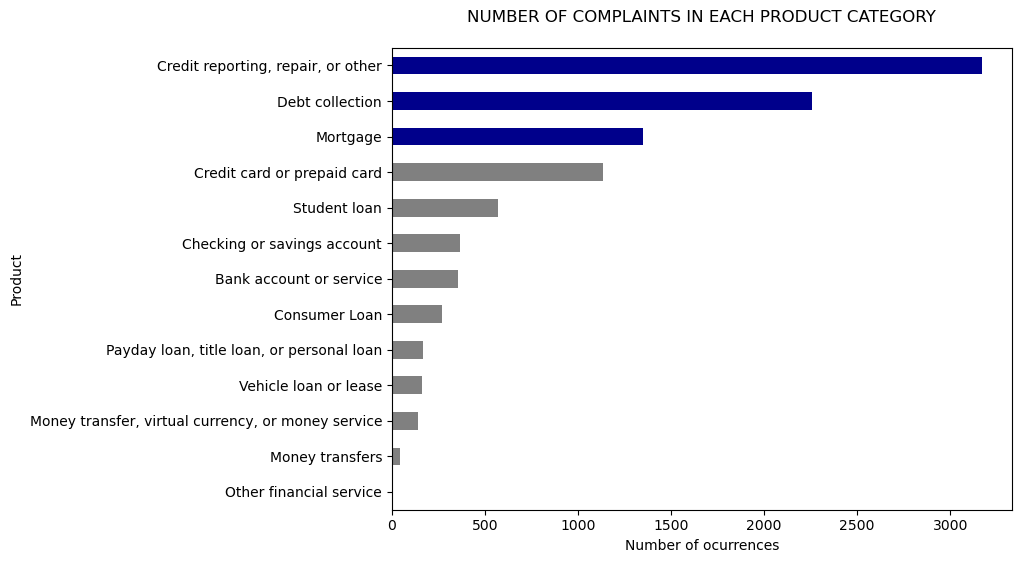

In [42]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

<a id='pre'></a>
## Text Preprocessing

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate __how important a word is to a document in a collection of documents__.

After removing __punctuation__ and __lower casing__ the words, importance of a word is determined in terms of its frequency.

### “Term Frequency – Inverse Document Frequency 

__TF-IDF__ is the product of the __TF__ and __IDF__ scores of the term.<br><br> $$\text{TF-IDF}=\frac{\text{TF}}{\text{IDF}}$$<br>

__Term Frequency :__ This summarizes how often a given word appears within a document.

$$\text{TF} = \frac{\text{Number of times the term appears in the doc}}{\text{Total number of words in the doc}}$$<br><br>
__Inverse Document Frequency:__ This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.<br>

$$\text{IDF} = \ln\left(\frac{\text{Number of docs}}{\text{Number docs the term appears in}} \right)$$<br>

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word _mortgage_ would be mentioned fairly often. However, if we look at other complaints, _mortgage_ probably would not show up in many of them. We can infer that _mortgage_ is most probably an important word in Mortgage complaints as compared to the other products. Therefore, _mortgage_ would have a high TF-IDF score for Mortgage complaints.

TfidfVectorizer class can be initialized with the following parameters:
* __min_df__: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.
* __max_df__: remove the words from the vocabulary which have occurred in more than _‘max_df’ * total number of files in corpus_.
* __sublinear_tf__: set to True to scale the term frequency in logarithmic scale.
* __stop_words__: remove the predefined stop words in 'english'.
* __use_idf__: weight factor must use inverse document frequency.
* __ngram_range__: (1, 2) to indicate that unigrams and bigrams will be considered.

In [43]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 27507 features (TF-IDF score of unigrams and bigrams)


In [44]:
# Finding the three most correlated terms with each product category
N = 3
for product, category_id in sorted(category_to_id.items()):
    # Calculate chi-square test statistics
    features_chi2 = chi2(features, labels == category_id)
    
    # Get indices of features sorted by chi-square statistic
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]  # Updated method name
    
    # Split into unigrams and bigrams
    unigrams = [v for v in feature_names if len(v.split()) == 1][-N:] # Take last N
    bigrams = [v for v in feature_names if len(v.split()) == 2][-N:]  # Take last N
    
    # Print results
    print(f"\n==> {product}:")
    print(f"  * Most Correlated Unigrams: {', '.join(unigrams)}")
    print(f"  * Most Correlated Bigrams: {', '.join(bigrams)}")
'''N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))'''


==> Bank account or service:
  * Most Correlated Unigrams: overdraft, bank, scottrade
  * Most Correlated Bigrams: citigold checking, debit card, checking account

==> Checking or savings account:
  * Most Correlated Unigrams: checking, branch, overdraft
  * Most Correlated Bigrams: 00 bonus, overdraft fees, checking account

==> Consumer Loan:
  * Most Correlated Unigrams: dealership, vehicle, car
  * Most Correlated Bigrams: car loan, vehicle loan, regional acceptance

==> Credit card or prepaid card:
  * Most Correlated Unigrams: express, citi, card
  * Most Correlated Bigrams: balance transfer, american express, credit card

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams: report, experian, equifax
  * Most Correlated Bigrams: credit file, equifax xxxx, credit report

==> Debt collection:
  * Most Correlated Unigrams: collect, collection, debt
  * Most Correlated Bigrams: debt collector, collect debt, collection agency

==> Money transfer, virtual currency, or

'N = 3\nfor Product, category_id in sorted(category_to_id.items()):\n  features_chi2 = chi2(features, labels == category_id)\n  indices = np.argsort(features_chi2[0])\n  feature_names = np.array(tfidf.get_feature_names())[indices]\n  unigrams = [v for v in feature_names if len(v.split(\' \')) == 1]\n  bigrams = [v for v in feature_names if len(v.split(\' \')) == 2]\n  print("\n==> %s:" %(Product))\n  print("  * Most Correlated Unigrams are: %s" %(\', \'.join(unigrams[-N:])))\n  print("  * Most Correlated Bigrams are: %s" %(\', \'.join(bigrams[-N:])))'

<a id='ml'></a>
## Multi-Classification models

The classification models evaluated are: 
* Random Forest
* Linear Support Vector Machine
* Multinomial Naive Bayes 
* Logistic Regression.

<a id='sp'></a>
### Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [45]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

<a id='m'></a>
### Models

In [46]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

<a id='sum'></a>
## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [47]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.7791,0.005561
LogisticRegression,0.7638,0.009543
MultinomialNB,0.6475,0.004596
RandomForestClassifier,0.3948,0.006554


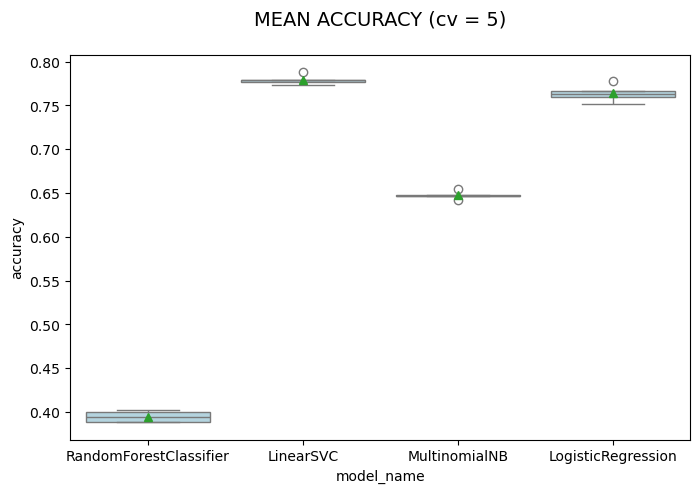

In [48]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

<a id='ev'></a>
## Model Evaluation

In [49]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<a id='m'></a>
### Precision, Recall, F1-score

In [50]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                                    precision    recall  f1-score   support

                Credit reporting, repair, or other       0.81      0.88      0.84       783
                                   Debt collection       0.76      0.80      0.78       588
                                     Consumer Loan       0.52      0.22      0.31        73
                       Credit card or prepaid card       0.73      0.82      0.77       253
                                          Mortgage       0.87      0.92      0.90       340
                             Vehicle loan or lease       0.43      0.14      0.21        43
                                      Student loan       0.85      0.85      0.85       155
         Payday loan, title loan, or personal loan       0.50      0.17      0.26        40
                       Checking or savings account       0.61      0.60      0.61        85
                           Bank account or service

c:\Users\rev\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rev\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rev\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


It is possible to observe that the classes with more support (number of occurrences) tend to have a better f1-cscore. This is because the algorithm was trained with more data.<br><br>
The classes that can be classified with more precision are __‘Mortgage’__, __‘Credit reporting, repair, or other’__, and __‘Student loan’__.

<a id='cm'></a>
### Confusion Matrix

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.<br><br>
If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).

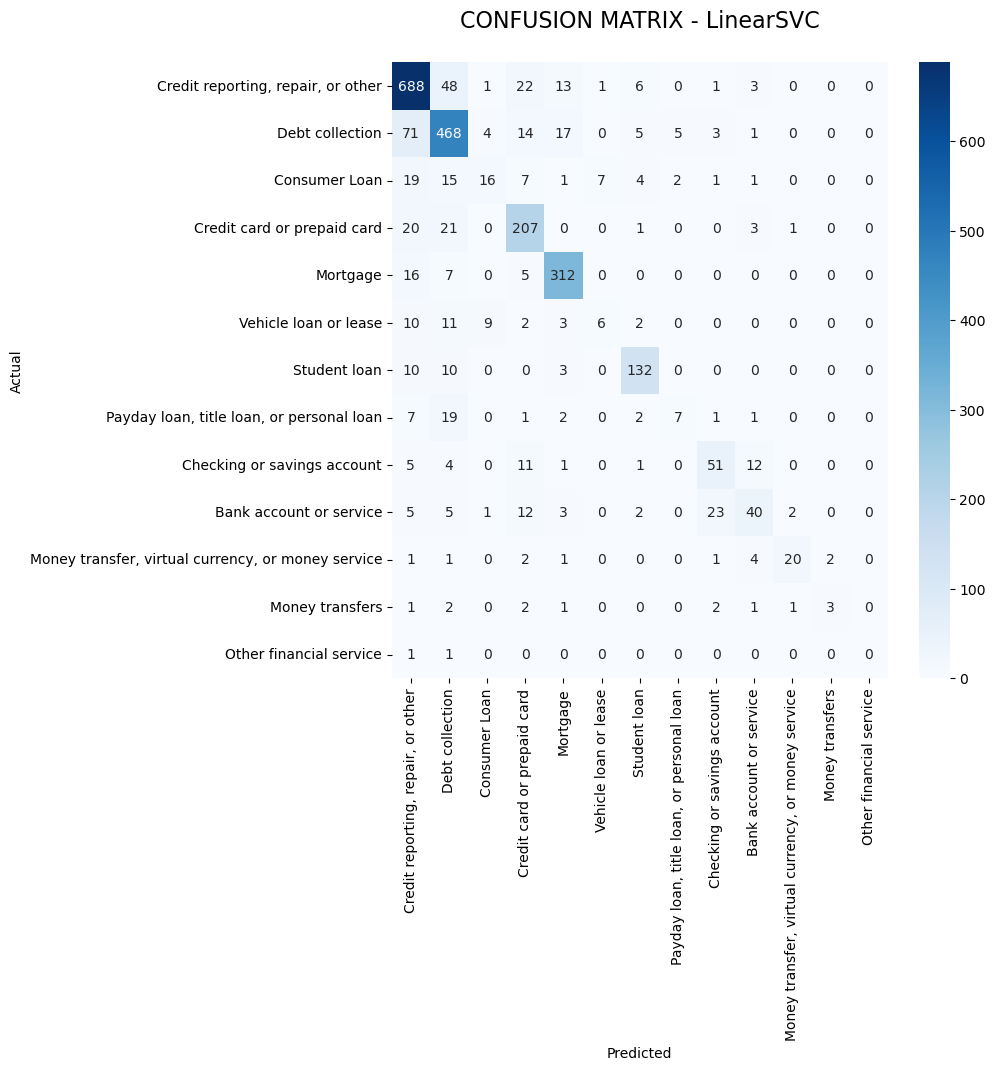

In [51]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In general, the confusion matrix looks good (clear diagonal that represents correct classifications). Nevertheless, there are cases were the complaint was classified in a wrong class.

#### Misclassified complaints
Let’s have a look at the cases that were wrongly classified.

In [52]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Consumer_complaint']])
      print('')

'Debt collection' predicted as 'Credit reporting, repair, or other' : 71 examples.


,Product,Consumer_complaint
483075,Debt collection,This agency has three collections listed which...
111807,Debt collection,I am writing to dispute the inaccurate data be...
376788,Debt collection,check n ' Go payday loan made me a loan and th...
570764,Debt collection,THIS AMT OWED {$8800.00} WAS TO BE PAID UNDER ...
88089,Debt collection,I am submitting this complaint for an account ...
...,...,...
155139,Debt collection,"Between XX/XX/XXXX and XX/XX/XXXX, this accoun..."
360018,Debt collection,"On XXXX XXXX, 2017 XXXX opened up an account f..."
165296,Debt collection,I have tried disputing with the bureau on seve...
159609,Debt collection,This is a complaint against National Credit Sy...



'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 20 examples.


,Product,Consumer_complaint
399397,Credit card or prepaid card,"On XXXX XXXX, XXXX I submitted correspondence ..."
752303,Credit card or prepaid card,I purchased a room size air conditioner from X...
544109,Credit card or prepaid card,To Whom May Concern : Early Spring XX/XX/XXXX ...
723669,Credit card or prepaid card,The Sychrony issued excessive credit to me thr...
202661,Credit card or prepaid card,I reviewed my credit report and saw an account...
891797,Credit card or prepaid card,I have a SYNCB/WALMART DUAL CARD. Unbeknownst ...
280866,Credit card or prepaid card,XX/XX/2017 Monthly payment XXXX dollars. I rea...
350390,Credit card or prepaid card,I received a letter from XXXX On XXXX XXXX 201...
413596,Credit card or prepaid card,"XXXX investigated the following listing, XXXX ..."
725609,Credit card or prepaid card,Seventh Ave has charged off an account and con...



'Credit reporting, repair, or other' predicted as 'Debt collection' : 48 examples.


,Product,Consumer_complaint
167717,"Credit reporting, repair, or other",When my vehicle was repossessed in XX/XX/2017 ...
131925,"Credit reporting, repair, or other",I submitted a dispute online on a debt with XX...
675868,"Credit reporting, repair, or other",My name is XXXX XXXX. Your collection agency i...
370575,"Credit reporting, repair, or other",Credit reporting agency incorrectly keeps repo...
863037,"Credit reporting, repair, or other",This medical bill was paid to another collecto...
597294,"Credit reporting, repair, or other","I received a call, and my oldest daughter got ..."
301509,"Credit reporting, repair, or other",While attempting to get approval for a loan to...
404336,"Credit reporting, repair, or other",On XX/XX/XXXX I sent a letter to Wakefield & A...
310415,"Credit reporting, repair, or other","Portfolio Recov Assoc, Promise to remove the c..."
347164,"Credit reporting, repair, or other",XXXX Inquired because someone is trying to use...



'Credit card or prepaid card' predicted as 'Debt collection' : 21 examples.


,Product,Consumer_complaint
427835,Credit card or prepaid card,XXXX would not honor an offer to credit {$50.0...
468331,Credit card or prepaid card,hi I 'm on payment program with American expre...
36821,Credit card or prepaid card,"I am corresponding about my XXXX XXXX XXXX, wh..."
681770,Credit card or prepaid card,I sent the following message to Capital One on...
859065,Credit card or prepaid card,I had several attempts to get information abou...
504540,Credit card or prepaid card,This is in regards to BOTH a Total Visa acco...
872562,Credit card or prepaid card,I used a debt relief agency to pay my debts ( ...
609682,Credit card or prepaid card,I have a letter stating from American Express ...
907179,Credit card or prepaid card,I keep getting a robo call ( XXXX ) threatenin...
517845,Credit card or prepaid card,Bank of America is refusing to produce proof o...



'Credit reporting, repair, or other' predicted as 'Credit card or prepaid card' : 22 examples.


,Product,Consumer_complaint
184965,"Credit reporting, repair, or other",XXXX is a company of XXXX and XXXX XXXX up my...
846410,"Credit reporting, repair, or other",There is incorrect credit card showing up on m...
192020,"Credit reporting, repair, or other",I went to the Capital One web site to apply fo...
265650,"Credit reporting, repair, or other",XXXX XXXX XXXX reported my account as charged ...
301997,"Credit reporting, repair, or other","XXXX Barclay , XXXX and XXXX are not updating ..."
473355,"Credit reporting, repair, or other",Company : USAA Summary of events : About XXXX ...
257154,"Credit reporting, repair, or other",I had an automatic payment of {$50.00} schedul...
168845,"Credit reporting, repair, or other",It percieved XXXX and other credit reporting a...
421206,"Credit reporting, repair, or other",Unable to get by bots or reach by telephone. C...
49300,"Credit reporting, repair, or other",In XX/XX/XXXX I needed a credit card to use to...



'Bank account or service' predicted as 'Checking or savings account' : 23 examples.


,Product,Consumer_complaint
655179,Bank account or service,My email is XXXXXXXXXXXX and I never got to pr...
540543,Bank account or service,HSBC refuses to confirm the date my account wa...
655963,Bank account or service,Bank of America has charged me numerous XXXX f...
593920,Bank account or service,My complaint is with Capital One 360 ; they do...
692350,Bank account or service,"My name is XXXX, I am my father 's heir & the ..."
760899,Bank account or service,I have a XXXX IRA with Capital One 360. My mob...
674009,Bank account or service,"On XXXX XXXX 2016, I 'd visited the Wells Farg..."
541558,Bank account or service,On XXXX my husband deposited {$400.00} through...
547387,Bank account or service,"On XX/XX/XXXX, a merchant presented an electro..."
816633,Bank account or service,On XXXX I deposited an insurance claim check (...


#### Most correlated terms with each category

In [53]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

<a id='pred'></a>
## Predictions

Now let's make a few predictions on unseen data.<br>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

Let's see what is the classification that our model gives to this new complaint.

In [ ]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

The algorithm has classified this text as a "Student loan" complaint. Now let's look at the real label of this complaint.

In [ ]:
df2[df2['Consumer_complaint'] == new_complaint]

Our model was correct, the complaint was about **Student Loan**. Note that this customer has used terms with high TFIDF score, such us **Navient[](http://)**.<br><br>
Let's check another example.

In [ ]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

In [ ]:
df2[df2['Consumer_complaint'] == new_complaint_2]

Again, the algorithm correctly classified the caomplaint as __"Credit reporting, repair, or other"__. Note that this customer has used terms with high TFIDF score, such us __equifax, report__. <br><br>
Although our model is not going to be all the time correct when classifying new complaints, it does a good job.